# Problem 1

** Problem 1 **: *Censored data fitting* (2 points). 

In [1]:
import numpy as np
from numpy.random import randn
from cvxpy import *
import scipy.io as sio
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from PIL import Image

### Data generating

In [5]:
np.random.seed(1)
n = 2;  # dimension of x's
M = 3;  # number of non-censored data points
K = 5; # total number of points

c_true = randn(n)
X = randn(n, K)
y = np.dot(X.T, c_true) + 0.1 * np.sqrt(n) * randn(K)

# Reorder measurements, then censor
sort_ind = np.argsort(y)
X = X[:, sort_ind]
y = y[sort_ind[:M + 1]]
D = (y[M - 1]+y[M]) / 2
y = y[:M]

We have the following optimization problem

$$\begin{align}
\text{minimize}\hspace{5mm}\sum_{k=1}^M(y_k - c^Tx_k)^2 + \sum_{i=M+1}^K(z_i - c^Tx_i)^2\\
\text{subject to}\hspace{24mm} z_i>D,\ i=k+1,\ldots, K
\end{align}$$

In [6]:
C = Variable(n)
Z = Variable(K-M)

objective = Minimize(norm(y - X[:, range(M)].T * C, 2) ** 2 + norm(Z - X[:, range(M, K)].T * C, 2) ** 2)
constraints = [Z > D]
prob = Problem(objective, constraints)
print 'opt value = ', prob.solve()
print 'status =', prob.status
c_hat = C.value

opt value =  0.000365553475409
status = optimal


### Another data

In [7]:
n = 20;  # dimension of x's
M = 25;  # number of non-censored data points
K = 100; # total number of points

np.random.seed(1)
c_true = randn(n)
X = randn(n, K)
y = np.dot(X.T, c_true) + 0.1 * np.sqrt(n) * randn(K)

# Reorder measurements, then censor
sort_ind = np.argsort(y)
X = X[:, sort_ind]
y = y[sort_ind[:M + 1]]
D = (y[M - 1]+y[M]) / 2
y = y[:M]

#### Censored

In [8]:
C = Variable(n)
Z = Variable(K-M)

objective = Minimize(norm(y - X[:, range(M)].T * C, 2) ** 2 + norm(Z - X[:, range(M, K)].T * C, 2) ** 2)
constraints = [Z > D]
prob = Problem(objective, constraints)
print 'opt value = ', prob.solve()
print 'status =', prob.status
c_hat = C.value

opt value =  1.88603331455
status = optimal


#### Only uncensored

We use cutted version of primal objective function

$$\sum_{k=1}^M(y_k - c^Tx_k)^2$$

So we take into account only uncensored data.

In [9]:
C = Variable(n)

objective = Minimize(norm(y - X[:, range(M)].T * C, 2) ** 2)
prob = Problem(objective)
print 'opt value = ', prob.solve()
print 'status =', prob.status
c_hat_ls = C.value

opt value =  0.904051136429
status = optimal


#### Relative errors

In [10]:
c_true = c_true.reshape(20, 1)

In [11]:
err = np.linalg.norm(c_true - c_hat, 'fro') / np.linalg.norm(c_true, 'fro')
err_ls = np.linalg.norm(c_true - c_hat_ls) / np.linalg.norm(c_true)
print 'err =', err
print 'err_ls =', err_ls

err = 0.0890349949783
err_ls = 0.227096701678


$$\frac{\|c_\text{true} - \hat{c}\|_2}{\|c_\text{true}\|_2} = 0.0890349949783$$

$$\frac{\|c_\text{true} - \hat{c}_\text{ls}\|_2}{\|c_\text{true}\|_2} = 0.22709670166$$

# Problem 2

** Problem 2 **: *Optimal vehicle speed scheduling (3 points) *-- (additional exercise A3.20 to Boyd and Vandenberghe). 

A vehicle (say, an airplane) travels along a fixed path of *n* segments, between *n + 1* waypoints labeled *0, . . . , n*. Segment *i* starts at waypoint *i − 1* and terminates at waypoint *i*. The vehicle starts at time *t = 0* at waypoint *0*. It travels over each segment at a constant (nonnegative) speed; *si* is the speed on segment *i*. We have lower and upper limits on the speeds: *smin ≤ s ≤ smax*. The vehicle does not stop at the waypoints; it simply proceeds to the next segment. The travel distance of segment *i* is *di* (which is positive), so the travel time over segment *i* is *di/si*. We let *τi*, *i = 1, . . . , n,* denote the time at which the vehicle arrives at waypoint *i*. The vehicle is required to arrive at waypoint *i*, *for i = 1, . . . , n*, between times *τmin,i* and *τmax,i* , which are given. The vehicle consumes fuel over segment *i* at a rate that depends on its speed *Φ(s_i )=a s_i^2+b s_i+c kg/s*.

You are given the data *d* (segment travel distances), *smin* and *smax* (speed bounds), *τmin* and *τmax* (waypoint arrival time bounds), and the the parameters *a*, *b*, and *c* (all parameters are in *veh_speed_sched_data.m*). For the given form of the potentials, find the way to reduce the problem to a convex optimization problem and solve it using CVX (NB: you need not necessarily use one of the “canonical” convex optimization formulations we saw in the course). Use step function to plot speed vs time for the optimal schedule.  What are relative pros and cons for using convex optimization vs. dynamic programming for such task?

In [2]:
mat_contents = sio.loadmat('veh_sched_data.mat')

a = mat_contents['a']
b = mat_contents['b']
c = mat_contents['c']
d = mat_contents['d']
n = mat_contents['n']
smin = mat_contents['smin']
smax = mat_contents['smax']
tau_min = mat_contents['tau_min']
tau_max = mat_contents['tau_max']

a, b, c, n = a[0][0], b[0][0], c[0][0], n[0][0] 

Our objective function is 

$$\sum_{i=1}^n \left(as_i^2 + bs_i +c\right)\cdot\frac{d_i}{s_i}$$

Formula for $t_i$ and $\tau_i$:

$$t_i = \frac{d_i}{s_i}$$
$$\tau_i = \tau_{i-1} + t_{i}$$

In matrix form

$$\overline{\tau} = \begin{bmatrix}
1 && 0 && \dots && 0\\
1 && 1 && \dots && 0\\
\vdots && \vdots && \ddots && \vdots\\
1 && 1 && \dots && 1
\end{bmatrix}\cdot\overline{t}$$

So we have optimization problem

$$\begin{align}
\text{minimize}\hspace{5mm}\sum_{i=1}^n \left(as_i^2 + bs_i +c\right)\cdot\frac{d_i}{s_i}\\
\text{subject to}\hspace{15mm} \tau_{\text{min}, i}\leq\tau_i\leq\tau_{\text{max}, i}\\
s_\text{min}\leq s_i \leq s_\text{max}
\end{align}$$

We solve problem for $s_i:=\frac{1}{s_i}$. So according to these notations we have an optimization problem

$$\begin{align}
\text{minimize}\hspace{5mm}\sum_{i=1}^n \left(a\frac{1}{s_i^2} + b\frac{1}{s_i} +c\right)\cdot d_is_i\\
\text{subject to}\hspace{23mm} \tau_{\text{min}, i}\leq\tau_i\leq\tau_{\text{max}, i}\\
\frac{1}{s_\text{max}}\leq s_i \leq \frac{1}{s_\text{min}}
\end{align}$$

In this case $t_i = d_is_i$. The formula for $\overline{\tau}$ is the same.

In [17]:
s = Variable(n) # s = 1 / speed

low_diag_ones = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        if i >= j:
            low_diag_ones[i][j] = 1

time = mul_elemwise(d, s)
t = low_diag_ones * time

# objective = Minimize((a * sum_squares(s) + b * sum_entries(s) + c * n))
objective = Minimize(sum_entries(mul_elemwise(d * a, inv_pos(s))) + \
                     sum_entries(d * b) + \
                     sum_entries(mul_elemwise(d * c, s)))

constraints = [s <= 1 / smin, s >= 1 / smax, tau_min <= t, t <= tau_max]

prob = Problem(objective, constraints)
print 'optimal amount of fuel =', prob.solve()
print 'status =', prob.status
speed = 1 / s.value
tau = np.asarray(t.value)

optimal amount of fuel = 2617.82519355
status = optimal


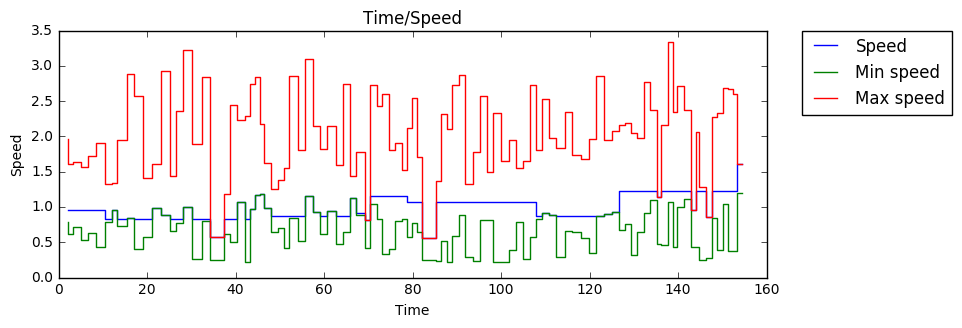

In [19]:
%matplotlib inline
fig = plt.figure(figsize=(8, 6))

speedplot = fig.add_subplot(2,1,1)
speedplot.step(tau, speed, label='Speed')
speedplot.step(tau, smin, label='Min speed')
speedplot.step(tau, smax, label='Max speed')
speedplot.set_title('Time/Speed')
speedplot.set_xlabel('Time')
speedplot.set_ylabel('Speed')
speedplot.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.tight_layout()

plt.show()

Solving this problem via CVXPY package is more efficient due to variety of proposed methods. Dynamic programming requires discretization of different parameters which implies inaccuracies and the accumulation of errors.

# Problem 3

 We have an optimization problem
 
$$\begin{align}
\text{minimize}\hspace{12mm}p^Tx\\
\text{subject to}\hspace{5mm}Ax\leq b\\
Cx=d
\end{align}$$

Lagrangian of this problem:

$$\mathcal{L}(x, \lambda, \mu) = p^Tx + \lambda^T(Ax-b) +\mu^T(Cx-d) = (p^T + \lambda^TA + \mu^TC)x - \lambda^Tb - \mu^Td$$

The dual objective function is

$$g(\lambda, \mu) = \inf_x\mathcal{L} = -\lambda^Tb - \mu^Td$$

because $\nabla_x\mathcal{L} = p^T + \lambda^TA + \mu^TC =0$. So the dual optimization problem looks like following

$$\begin{align}
\text{maximize}\hspace{18mm}-\lambda^Tb - \mu^Td\\
\text{subject to}\hspace{5mm}p^T + \lambda^TA + \mu^TC =0\\
\lambda, \mu\geq 0
\end{align}$$

# Problem 4

## Primal problem
Set

$$P=\begin{bmatrix}
2 && 1\\
1 && 2
\end{bmatrix}$$

$$A = \begin{bmatrix}
-1 && -2\\
-3 && -1
\end{bmatrix},\ b =\begin{bmatrix}
-1\\
-1\end{bmatrix}$$

Then we can rewrite out optimization problem as follows

$$\begin{align}
\text{minimize}\hspace{5mm}\frac{1}{2}x^TPx\\
\text{subject to}\hspace{5mm}Ax \leq b\end{align}$$


In [ ]:
x = Variable(2)

P = 2 * np.array([[1, -0.5],[-0.5, 1]])
vector1 = np.array([1, 2])
vector2 = np.array([3, 1])
A = np.array([-vector1, -vector2])
b = -np.ones(2)

objective = Minimize(0.5 * quad_form(x, P))
constraints = [A * x <= b]

prob = Problem(objective, constraints)
print 'opt value = ', prob.solve()
print 'status =', prob.status
print 'solution =', x.value[0], x.value[1]
x_sol = x.value

## Dual problem

Let
$$\mathcal{L} = \frac{1}{2}x^TPx + \lambda^T(Ax-b)$$
be a lagrnagian of our problem. The dual function is 
$$g(\lambda) = \inf_x \mathcal{L} = -\frac{1}{2}\lambda^T\tilde{P}\lambda - \lambda^Tb$$
where
$$\tilde{P} = AP^{-1}A^T$$
So we obtain dual optimization problem

$$\begin{align}
    \text{maximize}\hspace{5mm}g(\lambda)\\
    \text{subject to}\hspace{3mm}\lambda\geq 0
\end{align}$$

In [ ]:
P_tilde = A.dot(np.linalg.inv(P).dot(A.T))
print P_tilde

In [ ]:
lambd = Variable(2)
b = -np.ones(2)

dual_objective = Maximize(-0.5 * quad_form(lambd, P_tilde) - lambd.T * b)
dual_constraints = [lambd >= 0]

dual_prob = Problem(dual_objective, dual_constraints)
print 'opt value = ', dual_prob.solve()
print 'status =', dual_prob.status
print 'solution =', lambd.value[0], lambd.value[1]
lambd_sol = lambd.value

### KKT conditions:

* $x^TP + \lambda^TA = 0$ (gradient vanishing)

In [ ]:
np.round(P.T.dot(x_sol) + A.T.dot(lambd_sol), 4) == 0

* $Ax - b \leq 0$ (primal feasibility)

In [ ]:
np.round(x_sol.T.dot(P.dot(x_sol) + A.T.dot(lambd_sol)), 7) == 0

* $\lambda^T(Ax -b) = 0$ (complementary slackness)

In [ ]:
np.round(lambd_sol.T.dot(A.dot(x_sol) - b.reshape(2, 1)), 7) == 0

* $\lambda\geq 0$ (dual feasibility)

In [ ]:
lambd_sol >= 0

# Problem 5

1) We have an optimization problem

$$\begin{align}
\text{minimize}\hspace{12mm}c^Tx\\
\text{subject to}\hspace{5mm}Ax\leq b\\
x_i\in\{0,1\}
\end{align}$$

The (partial) Lagrngian

$$\mathcal{L}(x, \lambda) = c^Tx + \lambda^T(Ax-b)$$

The dual function

$$g(\lambda) = \min_{x_i\in\{0,1\}} (c^T + \lambda^TA)x - \lambda^Tb = - \lambda^Tb + \sum_i \min\left(0, [c^T + \lambda^TA]_i\right)$$

2) In the case of optimization problem

$$\begin{align}
\text{minimize}\hspace{9mm}-x_1-2x_2-4x_3-3x_4\\
\text{subject to}\hspace{5mm}10x_1+10x_3+10x_4\leq 15\\
10x_1+10x_2+10x_4\leq 13\\
x_i\in\{0,1\}
\end{align}$$


$$c =\begin{bmatrix}
-1\\
-2\\
-4\\
-3
\end{bmatrix},\hspace{5mm}A =\begin{bmatrix}
10 && 0 && 10 && 10\\
10 && 10 && 0 && 10
\end{bmatrix},\hspace{5mm}b = \begin{bmatrix}
15\\
13
\end{bmatrix}$$

In [31]:
xgrid, ygrid = np.mgrid[0:10:0.05,0:10:0.05]
b = np.array([15, 13])
c = np.array([-1,-2,-4,-3])
A = np.array([[10, 0, 10, 10],[10, 10, 0, 10]])

Here we find $p^*$

In [32]:
x = Bool(4)

objective = Minimize(c.T * x)
constraints = [A * x <= b]
prob = Problem(objective, constraints)
prob.solve()

-6.0000000003205365

##### Dual function

In [33]:
l1, l2 = np.mgrid[0:10:0.05,0:10:0.05]
g = -15 * l1 - 13 * l2 + np.minimum(0, c[0] + 10 * l1 + 10 * l2) + \
                         np.minimum(0, c[1] + 10 * l2) + \
                         np.minimum(0, c[2] + 10 * l1) +\
                         np.minimum(0, c[3] + 10 * l1 + 10 * l2)

Using matplotlib backend: Qt5Agg


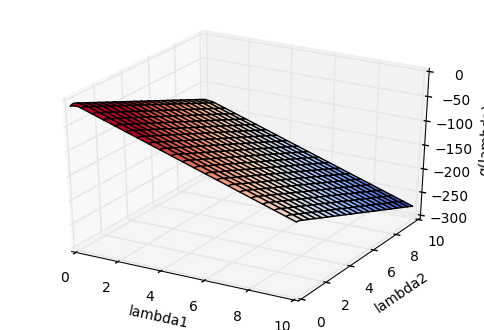

In [34]:
%matplotlib
# six = np.ones((200, 200)) * -6
fig = plt.figure()
plot = fig.add_subplot(111, projection='3d')
plot.plot_surface(l1, l2, g, cmap=cm.coolwarm, vmax = -50)
# plot.plot_surface(l1, l2, six)
plot.set_xlabel('lambda1')
plot.set_ylabel('lambda2')
plot.set_zlabel('g(lambda)')

plt.show()

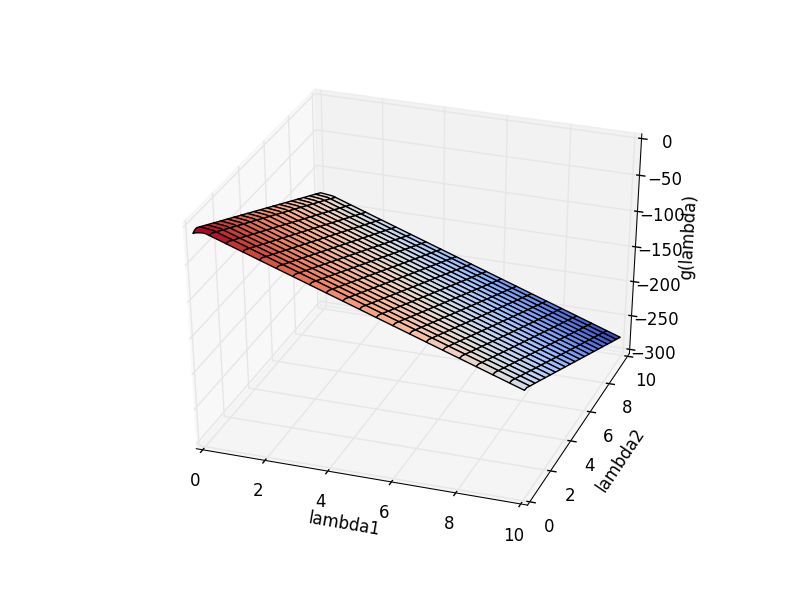

In [6]:
Image.open('C:/Users/Evgeny/Opt. methods/figure_1.png')

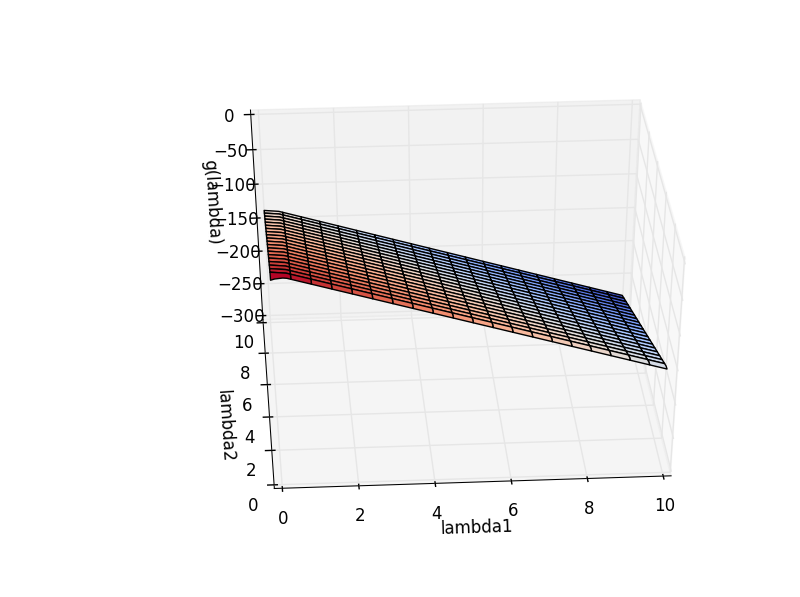

In [7]:
Image.open('C:/Users/Evgeny/Opt. methods/figure_2.png')

Here is $d^*$

In [8]:
np.max(g)

-7.0999999999999996

We can see that there is a duality gap, i.e. $d^*< p^*$, so strong duality doesn't hold.

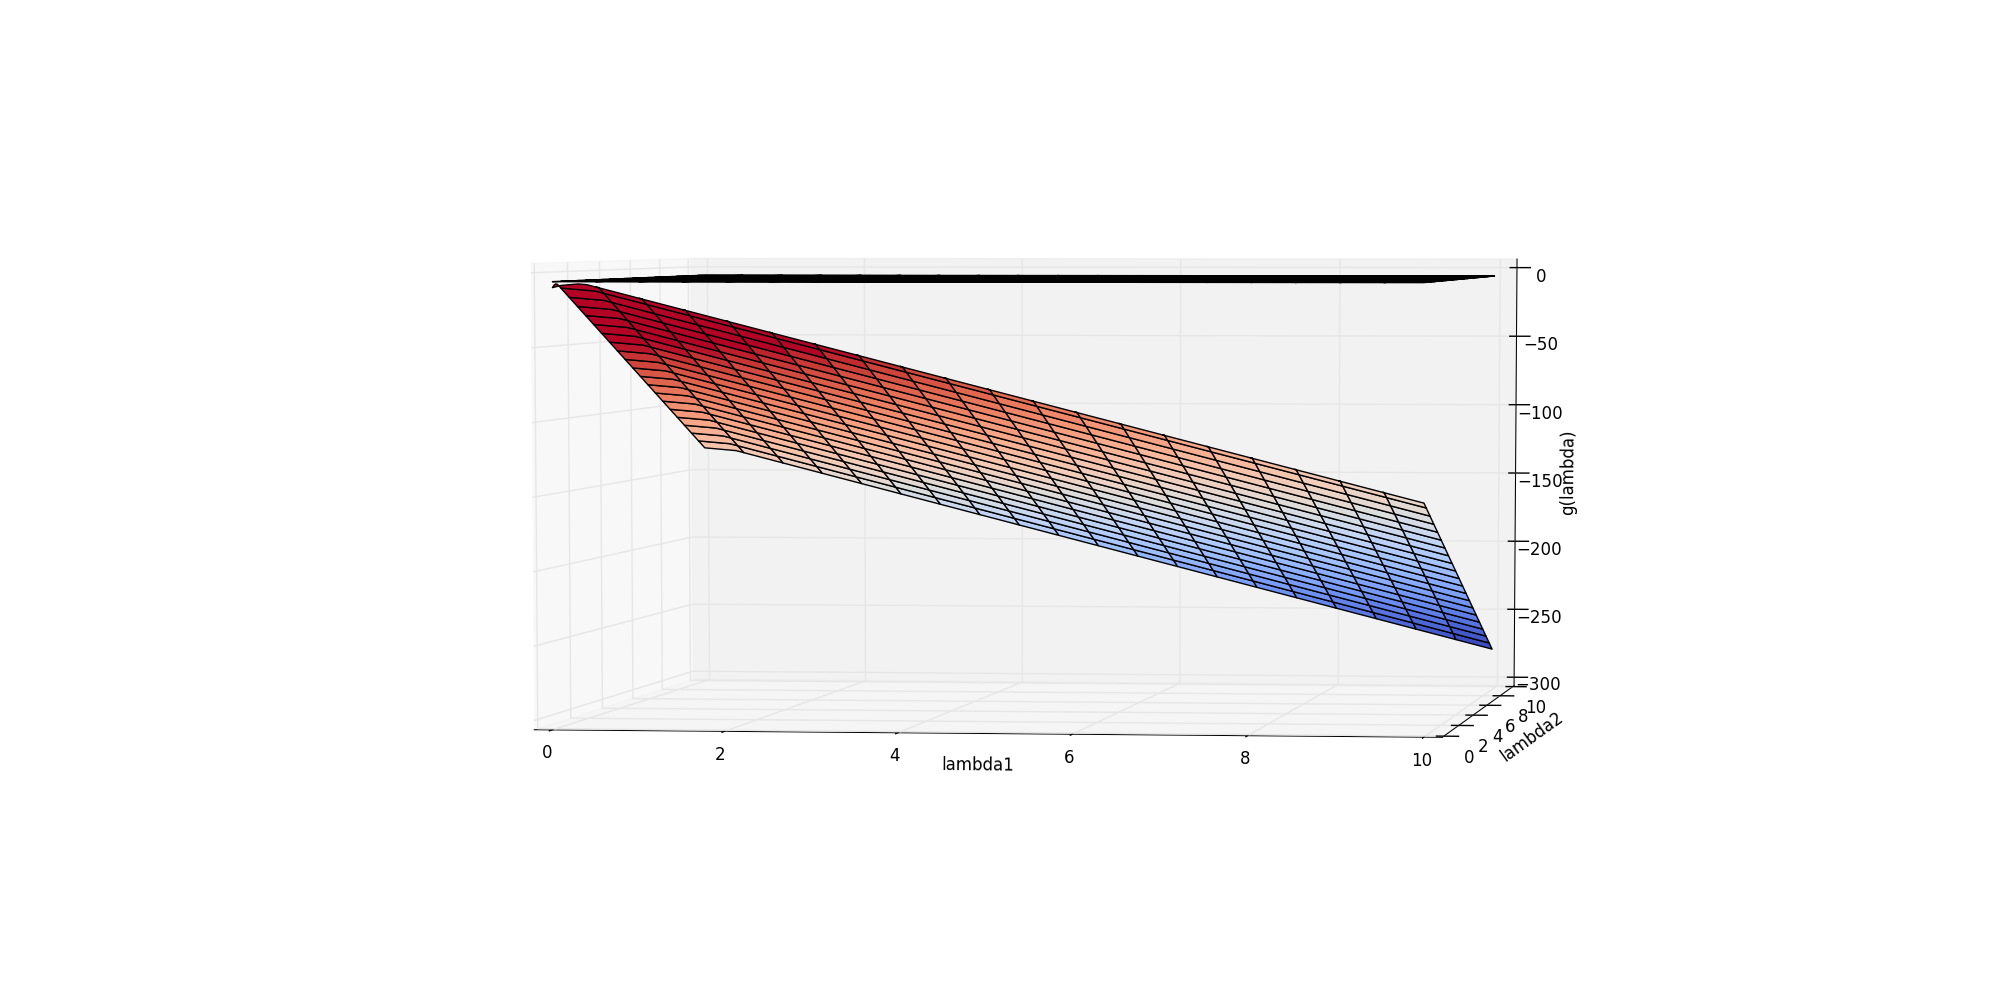

In [9]:
Image.open('C:/Users/Evgeny/Opt. methods/figure_3.png')

In [36]:
neg(x).value

matrix([[ 0.],
        [ 0.],
        [ 0.],
        [ 0.]])